In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class MammographyPreprocessor():
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size

    def Load_preprocess_image(self, image_path):
        try:
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"couldn't load the image {image_path}")
            image_resized = cv2.resize(img, self.target_size)
            image_normalized = image_resized.astype(np.float32) / 255.0
            # applying CLAHE: Contrast Limited Adaptative Histogram Equalization:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image_enhanced = clahe.apply((image_normalized * 255).astype(np.uint8))
            image_enhanced = image_enhanced.astype(np.float32) / 255.0
            return image_enhanced
        except Exception as e:
            print(f"Error Processing image {image_path}:{e}")
            return None

    def process_dataset(self, csv_path, image_folder_path):
        # Load CSV
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} records from CSV")

        images = []
        labels = []

        for idx, row in df.iterrows():
            # Get image path from CSV (try crop first, then others)
            img_path = None
            for col in ['jpg_crop_img_path', 'jpg_ROI_img_path', 'jpg_fullMammo_img_path']:
                if col in df.columns and not pd.isna(row[col]):
                    img_path = row[col]
                    break

            if img_path is None:
                continue

            # Find the actual image file - FIXED TO INCLUDE jpg_img FOLDER
            possible_paths = [
                os.path.join(image_folder_path, 'jpg_img', img_path),
                os.path.join(image_folder_path, 'jpg_img', os.path.basename(img_path)),
                os.path.join(image_folder_path, img_path),
                os.path.join(image_folder_path, os.path.basename(img_path)),
                os.path.join('jpg_img', img_path),
                os.path.join('jpg_img', os.path.basename(img_path))
            ]

            image_file = None
            for path in possible_paths:
                if os.path.exists(path):
                    image_file = path
                    break

            if image_file is None:
                continue

            # Process image
            processed_img = self.Load_preprocess_image(image_file)
            if processed_img is not None:
                images.append(processed_img)
                labels.append(row['pathology'])

            if len(images) % 100 == 0:
                print(f"Processed {len(images)} images...")

        print(f"Successfully processed {len(images)} images")
        return np.array(images), np.array(labels)

    def show_results(self, images, labels):
        """Show basic statistics and sample images"""
        print(f"\nDataset Summary:")
        print(f"Total images: {len(images)}")
        print(f"Image shape: {images[0].shape}")

        # Label distribution
        unique, counts = np.unique(labels, return_counts=True)
        print(f"\nLabel distribution:")
        for label, count in zip(unique, counts):
            print(f"  {label}: {count}")

        # Show sample images
        plt.figure(figsize=(12, 4))
        for i in range(min(4, len(images))):
            plt.subplot(1, 4, i+1)
            plt.imshow(images[i], cmap='gray')
            plt.title(f'Label: {labels[i]}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [13]:
def main():

    csv_file = "cleaned_data.csv"
    image_folder = "C:/Users/hp/Downloads/MAMMOGRAPHIE DIR/k_CBIS-DDSM/jpg_img"


    preprocessor =MammographyPreprocessor(target_size=(224,224))

    # Process dataset
    images, labels = preprocessor.process_dataset(csv_file, image_folder)

    if len(images) > 0:
        # Show results
        preprocessor.show_results(images, labels)

        # Convert labels to numbers
        le = LabelEncoder()
        numeric_labels = le.fit_transform(labels)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            images, numeric_labels, test_size=0.2, random_state=42
        )

        # Save everything
        np.save('images.npy', images)
        np.save('labels.npy', numeric_labels)
        np.save('X_train.npy', X_train)
        np.save('X_test.npy', X_test)
        np.save('y_train.npy', y_train)
        np.save('y_test.npy', y_test)

        print(f"\nSaved:")
        print(f"Training set: {len(X_train)} images")
        print(f"Test set: {len(X_test)} images")
        print(f"Files saved as .npy files")

    else:
        print("No images found. Check your file paths!")

if __name__ == "__main__":
    main()

Loaded 3568 records from CSV
Successfully processed 0 images
No images found. Check your file paths!


Image processed successfully!
Image shape: (224, 224)
Pixel range: 0.0117647061124444 to 0.9764705896377563


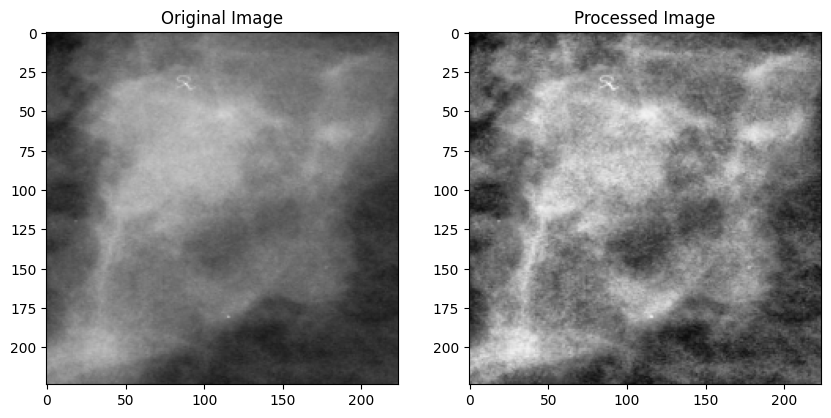

In [6]:
Preproccesor=MammographyPreprocessor(target_size=(224,224))
image_path="cropped-images-img_0-1.jpg"
processed_image=Preproccesor.Load_preprocess_image(image_path)
if processed_image is not None:
    print("Image processed successfully!")
    print(f"Image shape: {processed_image.shape}")
    print(f"Pixel range: {processed_image.min()} to {processed_image.max()}")
original_img=cv2.imread(image_path)
original_img=cv2.resize(original_img,(224,224))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_img,cmap='gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(processed_image,cmap='gray')
plt.title("Processed Image")
plt.show()